In [1]:
# MODIFY! 
# use Robust! 
model_name = 'ElNetRegRobNFE'

# Import Libraries & Data 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('./data/ul-nfe-ns.csv')
X = df.drop('throughput',axis=1)
y = df['throughput']

---

# Scale Data

In [4]:
# Split the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Scale the data
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
scaler.fit(X_train)

RobustScaler()

In [5]:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Determine Hyperparameters

In [6]:
# MODIFY!
from sklearn.linear_model import ElasticNetCV
model = ElasticNetCV(l1_ratio=[.1, .5, .7,.8,.9, .95, .99, 1],max_iter=1000000,cv=10)
model

ElasticNetCV(cv=10, l1_ratio=[0.1, 0.5, 0.7, 0.8, 0.9, 0.95, 0.99, 1],
             max_iter=1000000)

In [7]:
model.fit(X_train, y_train)

ElasticNetCV(cv=10, l1_ratio=[0.1, 0.5, 0.7, 0.8, 0.9, 0.95, 0.99, 1],
             max_iter=1000000)

In [8]:
model.l1_ratio_

1.0

In [9]:
model.alpha_

0.015519762464001195

In [10]:
hp = pd.Series(name=f'{model_name} HP', data=[model.l1_ratio_, model.alpha_],index=['l1_ratio','alpha'])

In [11]:
hp

l1_ratio    1.00000
alpha       0.01552
Name: ElNetRegRobNFE HP, dtype: float64

In [12]:
hp.to_csv(f'./hyperparameters/{model_name}-hp.csv')

# Score Model

In [13]:
# MODIFY!
from sklearn.linear_model import ElasticNet

score_model = ElasticNet(
    alpha = model.alpha_,
    l1_ratio = model.l1_ratio_
)

score_model

ElasticNet(alpha=0.015519762464001195, l1_ratio=1.0)

In [14]:
from sklearn.model_selection import cross_validate

scores = cross_validate(
    score_model, 
    X_train, 
    y_train,
    scoring=[
        'neg_mean_absolute_error',
        'neg_mean_squared_error',
        'neg_root_mean_squared_error'
    ],
    cv=10
)

In [15]:
scores = pd.DataFrame(scores)

In [16]:
scores

,fit_time,score_time,test_neg_mean_absolute_error,test_neg_mean_squared_error,test_neg_root_mean_squared_error
0,0.040285,0.002348,-4.065586,-24.825114,-4.982481
1,0.040642,0.007176,-5.092928,-40.122067,-6.334198
2,0.037956,0.001785,-4.374267,-28.538596,-5.342153
3,0.031010,0.002105,-4.365317,-28.723115,-5.359395
4,0.028043,0.002529,-4.577982,-32.878553,-5.733982
5,0.026048,0.002113,-4.940068,-38.770835,-6.226623
6,0.024725,0.002718,-4.313570,-28.761871,-5.363010
7,0.021751,0.002027,-4.135304,-26.606646,-5.158163
8,0.046262,0.001709,-4.798761,-33.676975,-5.803187
9,0.021184,0.006156,-4.690179,-32.255316,-5.679376


In [17]:
mean_scores = scores.mean()

In [18]:
mean_scores

fit_time                             0.031791
score_time                           0.003067
test_neg_mean_absolute_error        -4.535396
test_neg_mean_squared_error        -31.515909
test_neg_root_mean_squared_error    -5.598257
dtype: float64

# Export Model Score

In [19]:
mean_scores = mean_scores.rename(f'{model_name}')

In [20]:
mean_scores[[2,3,4]] = mean_scores[[2,3,4]].apply(abs)

In [21]:
# mean_scores

In [22]:
mean_scores = mean_scores.rename({
    'fit_time':'Fit Time',
    'score_time':'Score Time',
    'test_neg_mean_absolute_error':'MAE',
    'test_neg_mean_squared_error':'MSE',
    'test_neg_root_mean_squared_error':'RMSE'
})

In [23]:
mean_scores

Fit Time       0.031791
Score Time     0.003067
MAE            4.535396
MSE           31.515909
RMSE           5.598257
Name: ElNetRegRobNFE, dtype: float64

In [24]:
mean_scores['STD FT'] = scores.fit_time.std()
mean_scores['STD ST'] = scores.score_time.std()
mean_scores['STD MAE'] = scores.test_neg_mean_absolute_error.std()
mean_scores['STD MSE'] = scores.test_neg_mean_squared_error.std()
mean_scores['STD RMSE'] = scores.test_neg_root_mean_squared_error.std()

In [25]:
mean_scores

Fit Time       0.031791
Score Time     0.003067
MAE            4.535396
MSE           31.515909
RMSE           5.598257
STD FT         0.008874
STD ST         0.001937
STD MAE        0.342316
STD MSE        5.020957
STD RMSE       0.441500
Name: ElNetRegRobNFE, dtype: float64

In [26]:
mean_scores.to_csv(f'./scores/{model_name}-score.csv')

# Holdout Test

In [27]:
score_model.fit(X_train,y_train)

ElasticNet(alpha=0.015519762464001195, l1_ratio=1.0)

In [28]:
y_holdout = score_model.predict(X_test)

<AxesSubplot:ylabel='Count'>

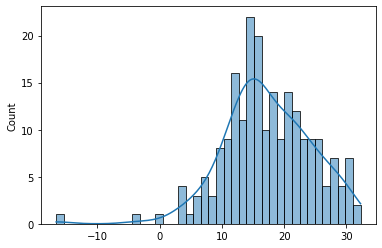

In [29]:
sns.histplot(y_holdout,bins=40,kde=True)

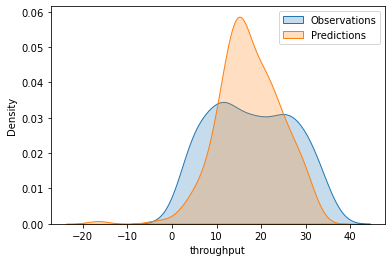

In [30]:
fig,ax = plt.subplots()

sns.kdeplot(y_test, ax=ax, shade=True, label='Observations')
sns.kdeplot(y_holdout, ax=ax,shade=True,label='Predictions')

ax.legend(loc='best')

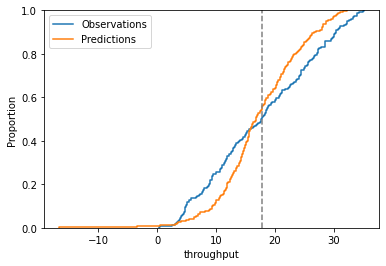

In [31]:
fig,ax = plt.subplots()

sns.ecdfplot(y_test, ax=ax, label='Observations')
sns.ecdfplot(y_holdout, ax=ax,label='Predictions')
plt.axvline(x=y_test.mean(),color='grey',linestyle='--')

ax.legend(loc='best')

In [32]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test,y_holdout)
mse = mean_squared_error(y_test,y_holdout)
rmse = np.sqrt(mse)

In [33]:
err_df = pd.DataFrame(data=[mae, mse, rmse],index=['MAE','MSE','RMSE'],columns=[f'{model_name}'])
err_df

,ElNetRegRobNFE
MAE,4.585929
MSE,33.817677
RMSE,5.815297


In [34]:
err_df.to_csv(f'./holdout-test/{model_name}-err.csv')
# mean_scores.to_csv(f'./opt-model-err/{model_name}-err.csv')

In [35]:
res = y_test - y_holdout
res.describe().drop('count')

mean     0.382109
std      5.816272
min    -15.696745
25%     -3.117717
50%      0.976941
75%      4.281004
max     17.116473
Name: throughput, dtype: float64

<AxesSubplot:xlabel='throughput', ylabel='Count'>

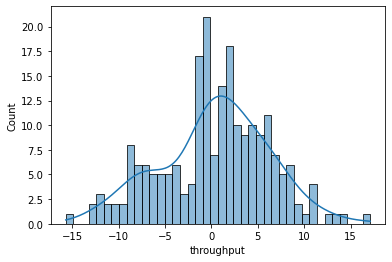

In [36]:
sns.histplot(data=res, kde=True,bins=40)

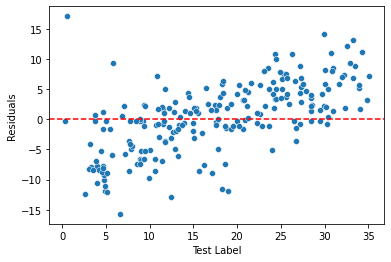

In [37]:
ax = sns.scatterplot(x=y_test, y=res)
ax.set(ylabel='Residuals', xlabel='Test Label')
plt.axhline(y=0,color='red',linestyle='--')

# there should be no clear pattern / curve in the plot
# we see a positive correlation between Test Label and Residuals -> later models should avoid this pattern

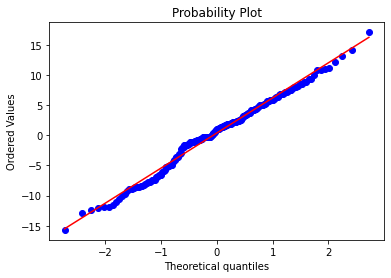

In [38]:
import scipy as sp

fig, ax = plt.subplots()
sp.stats.probplot(res,plot=ax);

# Export Optimized Model

In [39]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
scaler.fit(X)

RobustScaler()

In [40]:
# MODIFY! 
X = scaler.transform(X)

op_model = score_model

op_model.fit(X,y)

ElasticNet(alpha=0.015519762464001195, l1_ratio=1.0)

In [41]:
y_pred = op_model.predict(X)

<AxesSubplot:ylabel='Count'>

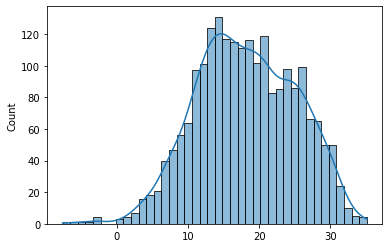

In [42]:
sns.histplot(y_pred,bins=40,kde=True)

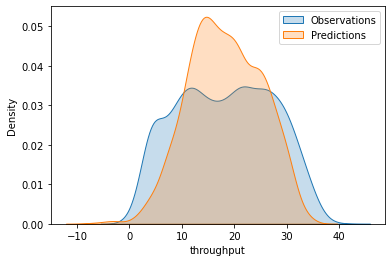

In [43]:
fig,ax = plt.subplots()

sns.kdeplot(y, ax=ax, shade=True, label='Observations')
sns.kdeplot(y_pred, ax=ax,shade=True,label='Predictions')

ax.legend(loc='best')

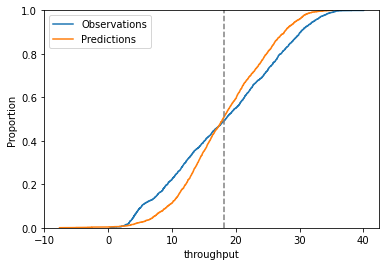

In [44]:
fig,ax = plt.subplots()

sns.ecdfplot(y, ax=ax, label='Observations')
sns.ecdfplot(y_pred, ax=ax,label='Predictions')
plt.axvline(x=y.mean(),color='grey',linestyle='--')

ax.legend(loc='best')

In [45]:
mae = mean_absolute_error(y,y_pred)
mse = mean_squared_error(y,y_pred)
rmse = np.sqrt(mse)

In [46]:
err_df = pd.DataFrame(data=[mae, mse, rmse],index=['MAE','MSE','RMSE'],columns=[f'{model_name}'])
err_df

,ElNetRegRobNFE
MAE,4.420835
MSE,29.920538
RMSE,5.469967


In [47]:
err_df.to_csv(f'./model-err/{model_name}-err.csv')
# mean_scores.to_csv(f'./opt-model-err/{model_name}-err.csv')

In [48]:
from joblib import dump, load
dump(op_model, f'./opt-models/{model_name}-model.joblib')

['./opt-models/ElNetRegRobNFE-model.joblib']

In [49]:
res = y - y_pred
res.describe().drop('count')

mean    5.572884e-16
std     5.471244e+00
min    -2.235388e+01
25%    -3.638164e+00
50%     4.528081e-01
75%     4.008525e+00
max     1.516669e+01
Name: throughput, dtype: float64

<AxesSubplot:xlabel='throughput', ylabel='Count'>

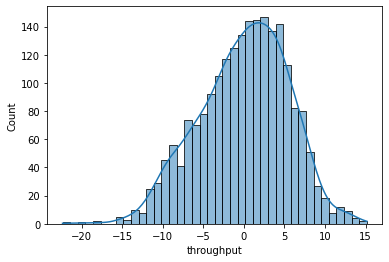

In [50]:
sns.histplot(data=res, kde=True,bins=40)

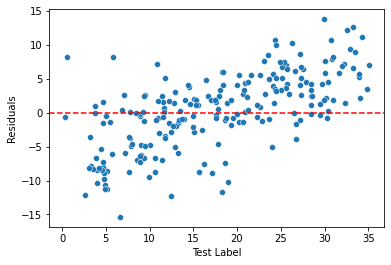

In [51]:
ax = sns.scatterplot(x=y_test, y=res)
ax.set(ylabel='Residuals', xlabel='Test Label')
plt.axhline(y=0,color='red',linestyle='--')

# there should be no clear pattern / curve in the plot
# we see a positive correlation between Test Label and Residuals -> later models should avoid this pattern

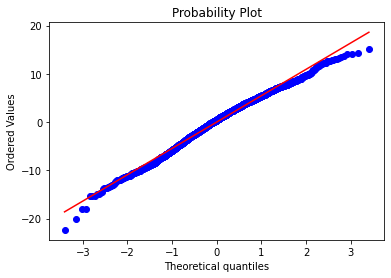

In [52]:
import scipy as sp

fig, ax = plt.subplots()
sp.stats.probplot(res,plot=ax);

DONE!